# Download bộ dữ liệu

Bộ dữ liệu Movielens 1M có thể được download trực tiếp từ trang chủ Movielens 1M hoặc sử dụng tabml.datasets

In [ ]:
!pip install tabml

# Import

In [ ]:
import matplotlib
import random as rd
import pandas as pd
import multiprocessing
import heapq
import scipy.sparse as sp
from matplotlib import pyplot as plt
from collections import OrderedDict
import numpy as np
from sklearn.metrics import roc_auc_score
from time import time

In [ ]:
# from google.colab import files

# for key, df in df_dict.items():
#     df.to_csv(f'{key}.csv', index=False)

# for key in df_dict.keys():
#     files.download(f'{key}.csv')

# Data analysis visualization

In [ ]:
import tabml.datasets
df_dict = tabml.datasets.download_movielen_1m()
df_dict.keys()

dict_keys(['users', 'movies', 'ratings'])

In [ ]:
users = df_dict['users']
movies = df_dict['movies']
ratings = df_dict['ratings']

## Tổng quan dữ liệu

<Axes: ylabel='Frequency'>

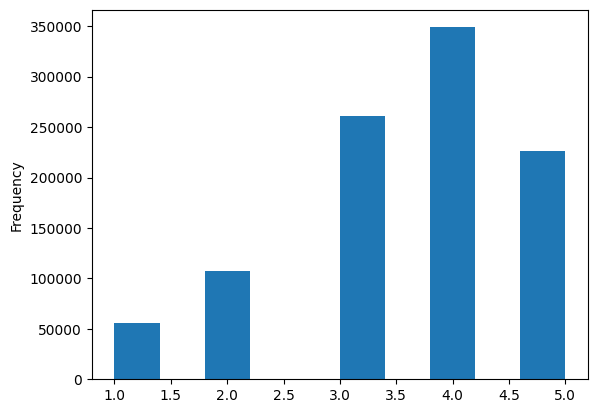

In [ ]:
ratings["Rating"].plot.hist()

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
ratings["UserID"].value_counts()

UserID
4169    2314
1680    1850
4277    1743
1941    1595
1181    1521
        ... 
5725      20
3407      20
1664      20
4419      20
3021      20
Name: count, Length: 6040, dtype: int64

In [ ]:
ratings["MovieID"].value_counts()

MovieID
2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3458       1
2226       1
1815       1
398        1
2909       1
Name: count, Length: 3706, dtype: int64

## Dữ liệu người dùng

In [ ]:
user = df_dict["users"]
user.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6040 entries, 0 to 6039
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   UserID      6040 non-null   int64 
 1   Gender      6040 non-null   object
 2   Age         6040 non-null   int64 
 3   Occupation  6040 non-null   int64 
 4   Zip-code    6040 non-null   object
dtypes: int64(3), object(2)
memory usage: 236.1+ KB


In [ ]:
users["Gender"].value_counts()

Gender
M    4331
F    1709
Name: count, dtype: int64

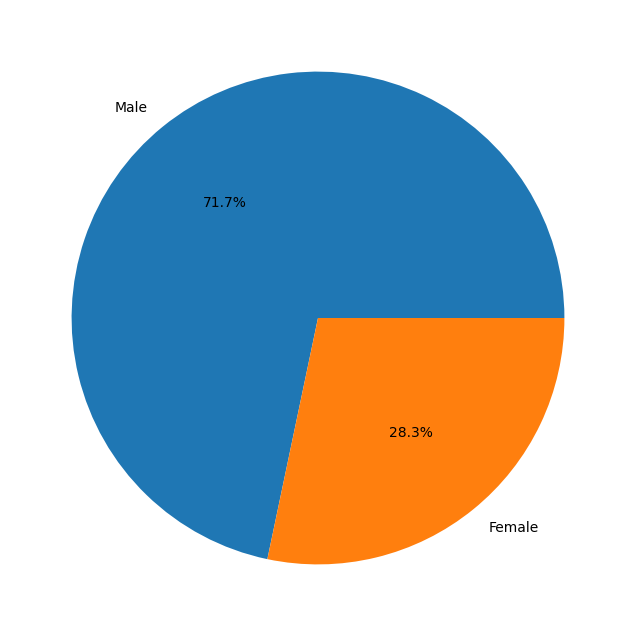

In [ ]:
gender = ['Male', 'Female']
gender_counts = users["Gender"].value_counts()

fig = plt.figure(figsize=(8,8))
plt.pie(gender_counts, labels=gender, autopct='%1.1f%%')
plt.show()

<Axes: >

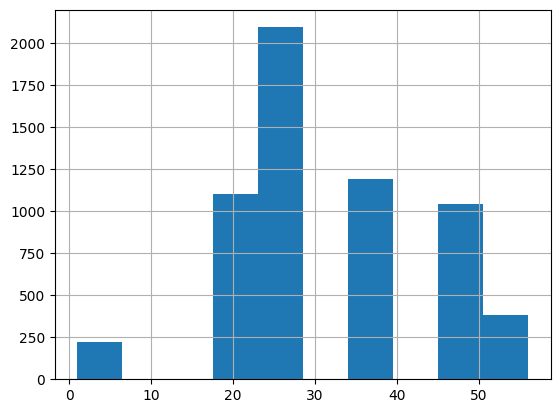

In [ ]:
users["Age"].hist()

Dữ liệu về nghề nghiệp đã được mã hóa thành các số từ 0 đến 20:

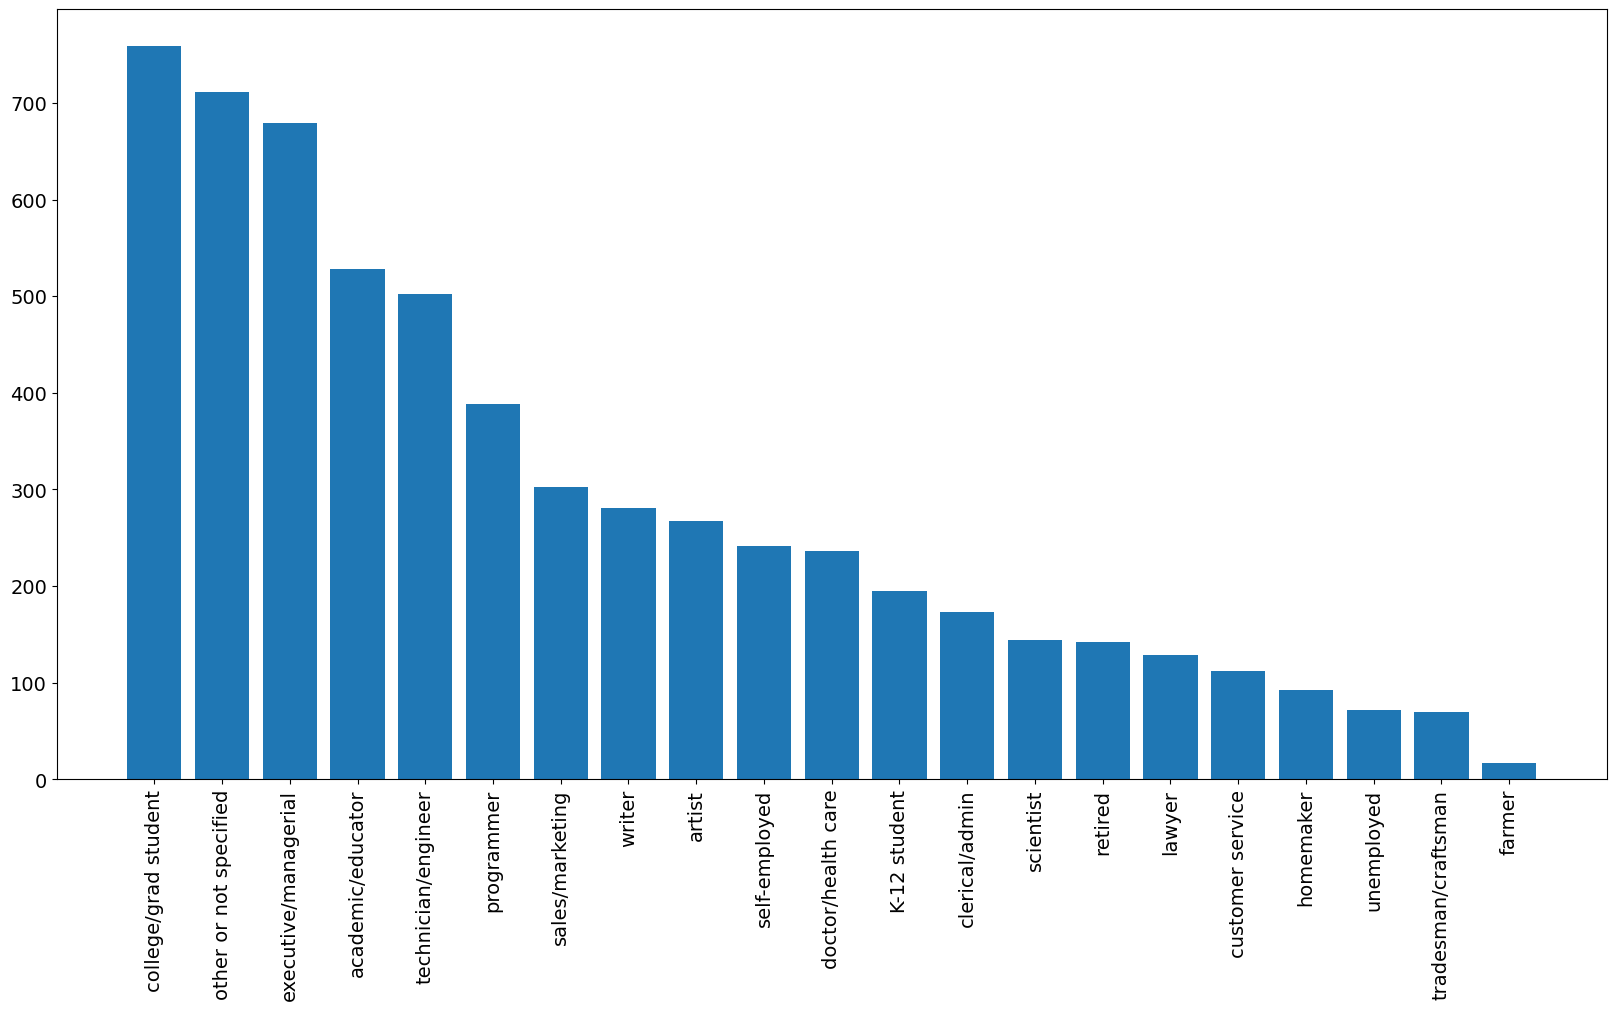

In [ ]:
occupation_mapping = {
    0: "other or not specified",
    1: "academic/educator",
    2: "artist",
    3: "clerical/admin",
    4: "college/grad student",
    5: "customer service",
    6: "doctor/health care",
    7: "executive/managerial",
    8: "farmer",
    9: "homemaker",
    10: "K-12 student",
    11: "lawyer",
    12: "programmer",
    13: "retired",
    14: "sales/marketing",
    15: "scientist",
    16: "self-employed",
    17: "technician/engineer",
    18: "tradesman/craftsman",
    19: "unemployed",
    20: "writer",
}

occupation_id_count = users["Occupation"].value_counts().to_dict()
occupation_count = {
    occupation_mapping[id]: count for id, count in occupation_id_count.items()
}


matplotlib.rcParams.update({"font.size": 14})
plt.figure(figsize=(20, 10))
plt.bar(x=occupation_count.keys(), height=occupation_count.values())
plt.xticks(rotation=90)
plt.show()

## Dữ liệu bộ film

In [ ]:
movies = df_dict["movies"]
movies.info

<bound method DataFrame.info of       MovieID                               Title  \
0           1                    Toy Story (1995)   
1           2                      Jumanji (1995)   
2           3             Grumpier Old Men (1995)   
3           4            Waiting to Exhale (1995)   
4           5  Father of the Bride Part II (1995)   
...       ...                                 ...   
3878     3948             Meet the Parents (2000)   
3879     3949          Requiem for a Dream (2000)   
3880     3950                    Tigerland (2000)   
3881     3951             Two Family House (2000)   
3882     3952               Contender, The (2000)   

                            Genres  
0      Animation|Children's|Comedy  
1     Adventure|Children's|Fantasy  
2                   Comedy|Romance  
3                     Comedy|Drama  
4                           Comedy  
...                            ...  
3878                        Comedy  
3879                         Drama  
3880                         Drama  
3881                         Drama  
3882                Drama|Thriller  

[3883 rows x 3 columns]>

In [ ]:
movies.head(10)

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
5,6,Heat (1995),Action|Crime|Thriller
6,7,Sabrina (1995),Comedy|Romance
7,8,Tom and Huck (1995),Adventure|Children's
8,9,Sudden Death (1995),Action
9,10,GoldenEye (1995),Action|Adventure|Thriller


Liệt kê các thể loại

In [ ]:
genres_list = movies['Genres'].str.split('|').tolist()

all_genres = list(set([genre for sublist in genres_list for genre in sublist]))

print("Danh sách các thể loại:")
for genre in all_genres:
    print(genre)

Danh sách các thể loại:
Western
Crime
Musical
Sci-Fi
Animation
Mystery
Comedy
Documentary
Drama
Action
Fantasy
War
Film-Noir
Thriller
Horror
Children's
Adventure
Romance


Dữ liệu về số lượng thể loại mà mỗi bộ phim thuộc về

In [ ]:
movies["num_genres"] = movies["Genres"].apply(lambda x: len(x.split('|')))
movies["num_genres"].value_counts()

num_genres
1    2025
2    1322
3     421
4     100
5      14
6       1
Name: count, dtype: int64

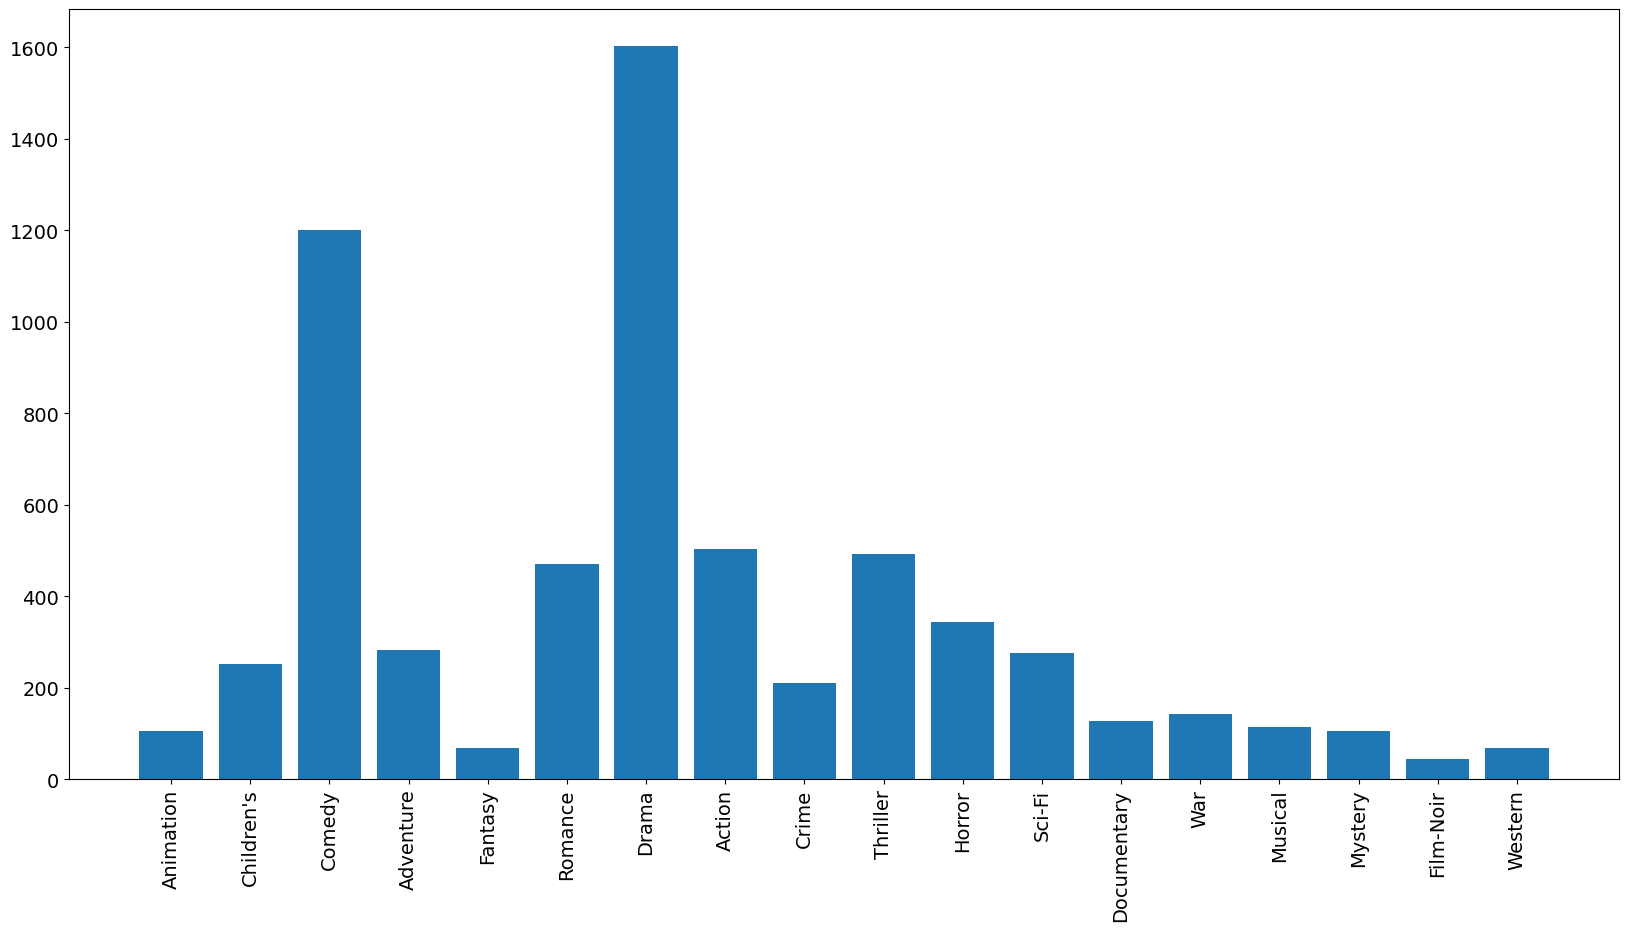

In [ ]:
from collections import defaultdict

genres_counter = defaultdict(int)
for genre_str in movies["Genres"]:
    genres = genre_str.split('|')
    for genre in genres:
        genres_counter[genre] += 1

plt.figure(figsize=(20, 10))
plt.bar(x=genres_counter.keys(), height=genres_counter.values())
plt.xticks(rotation=90)
plt.show();

Concat các bảng "users", "ratings", "movies" lại với nhau bằng từ khóa chung là "UserID" và "MovieID"

In [ ]:
merged_data = pd.merge(ratings, users, on='UserID')
merged_data = pd.merge(merged_data, movies, on='MovieID')

In [ ]:
merged_data.info()
merged_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 11 columns):
 #   Column      Non-Null Count    Dtype 
---  ------      --------------    ----- 
 0   UserID      1000209 non-null  int64 
 1   MovieID     1000209 non-null  int64 
 2   Rating      1000209 non-null  int64 
 3   Timestamp   1000209 non-null  int64 
 4   Gender      1000209 non-null  object
 5   Age         1000209 non-null  int64 
 6   Occupation  1000209 non-null  int64 
 7   Zip-code    1000209 non-null  object
 8   Title       1000209 non-null  object
 9   Genres      1000209 non-null  object
 10  num_genres  1000209 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 83.9+ MB


,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres,num_genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama,1
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama,1
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama,1
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama,1


Mean và mode rating của từng thể loại

In [ ]:
def mode(x):
    if x.empty:
        return None
    else:
        return x.mode().iloc[0]

mean_mode_by_genre = pd.DataFrame(columns=['Genre', 'Mean_Rating', 'Mode_Age', 'Mode_Occupation'])

for genre in all_genres:
    genre_data = merged_data[merged_data['Genres'].str.contains(genre)]

    mean_rating = genre_data['Rating'].mean()
    mode_age = mode(genre_data['Age'])
    mode_occupation = mode(genre_data['Occupation'])

    mean_mode_by_genre = pd.concat([mean_mode_by_genre, pd.DataFrame({
        'Genre': [genre],
        'Mean_Rating': [mean_rating],
        'Mode_Age': [mode_age],
        'Mode_Occupation': [mode_occupation]
    })], ignore_index=True)

print(mean_mode_by_genre)

          Genre  Mean_Rating Mode_Age Mode_Occupation
0       Western     3.637770       25               7
1         Crime     3.708679       25               4
2       Musical     3.665519       25               4
3        Sci-Fi     3.466521       25               4
4     Animation     3.684868       25               4
5       Mystery     3.668102       25               0
6        Comedy     3.522099       25               4
7   Documentary     3.933123       25               0
8         Drama     3.766332       25               0
9        Action     3.491185       25               4
10      Fantasy     3.447371       25               4
11          War     3.893327       25               0
12    Film-Noir     4.075188       25               0
13     Thriller     3.570466       25               4
14       Horror     3.215013       25               0
15   Children's     3.422035       25               4
16    Adventure     3.477257       25               4
17      Romance     3.607465

In [ ]:
mean_mode_by_genre.to_csv('mean_mode_by_genre.csv', index=False)

Dễ thấy rằng Drama và Comedy là hai thể loại có nhiều bộ phim nhất, vì vậy chúng ta sẽ cùng nhau phân tích kỹ hơn các dữ liệu liên quan đến 2 thể loại này

# Drama

In [ ]:
movies_drama = merged_data[merged_data['Genres'].str.contains('Drama')]
movies_drama.info()
movies_drama.head()

<class 'pandas.core.frame.DataFrame'>
Index: 354529 entries, 0 to 1000207
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   UserID      354529 non-null  int64 
 1   MovieID     354529 non-null  int64 
 2   Rating      354529 non-null  int64 
 3   Timestamp   354529 non-null  int64 
 4   Gender      354529 non-null  object
 5   Age         354529 non-null  int64 
 6   Occupation  354529 non-null  int64 
 7   Zip-code    354529 non-null  object
 8   Title       354529 non-null  object
 9   Genres      354529 non-null  object
 10  num_genres  354529 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 32.5+ MB


,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres,num_genres
0,1,1193,5,978300760,F,1,10,48067,One Flew Over the Cuckoo's Nest (1975),Drama,1
1,2,1193,5,978298413,M,56,16,70072,One Flew Over the Cuckoo's Nest (1975),Drama,1
2,12,1193,4,978220179,M,25,12,32793,One Flew Over the Cuckoo's Nest (1975),Drama,1
3,15,1193,4,978199279,M,25,7,22903,One Flew Over the Cuckoo's Nest (1975),Drama,1
4,17,1193,5,978158471,M,50,1,95350,One Flew Over the Cuckoo's Nest (1975),Drama,1


Độ tuổi

In [ ]:
mean_age_drama_viewers = movies_drama['Age'].mean() # giá trị trung bình độ tuổi
median_age_drama_viewers = movies_drama['Age'].median() # giá trị độ tuổi ở vị trí giữa của tập hợp các độ tuổi
mode_age_drama_viewers = movies_drama['Age'].mode() # độ tuổi xuất hiện nhiều nhất

print("Mean age of drama viewers:", mean_age_drama_viewers)
print("Median age of drama viewers:", median_age_drama_viewers)
print("Mode age of drama viewers:", mode_age_drama_viewers)

Mean age of drama viewers: 30.751049984627493
Median age of drama viewers: 25.0
Mode age of drama viewers: 0    25
Name: Age, dtype: int64


Giới tính

In [ ]:
gender_count_drama_viewers = movies_drama['Gender'].value_counts()

print("Gender distribution of drama viewers:", gender_count_drama_viewers)

Gender distribution of drama viewers: Gender
M    256376
F     98153
Name: count, dtype: int64


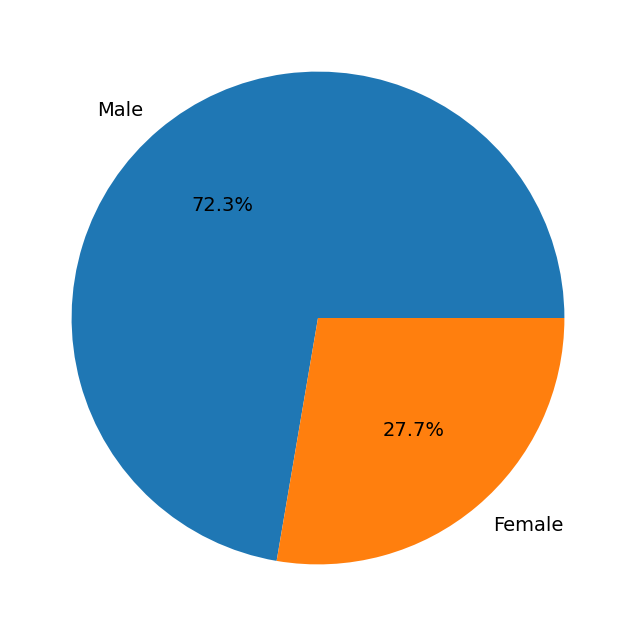

In [ ]:
gender = ['Male', 'Female']
gender_counts = movies_drama['Gender'].value_counts()

fig = plt.figure(figsize=(8,8))
plt.pie(gender_counts, labels=gender, autopct='%1.1f%%')
plt.show()

Nghề nghiệp

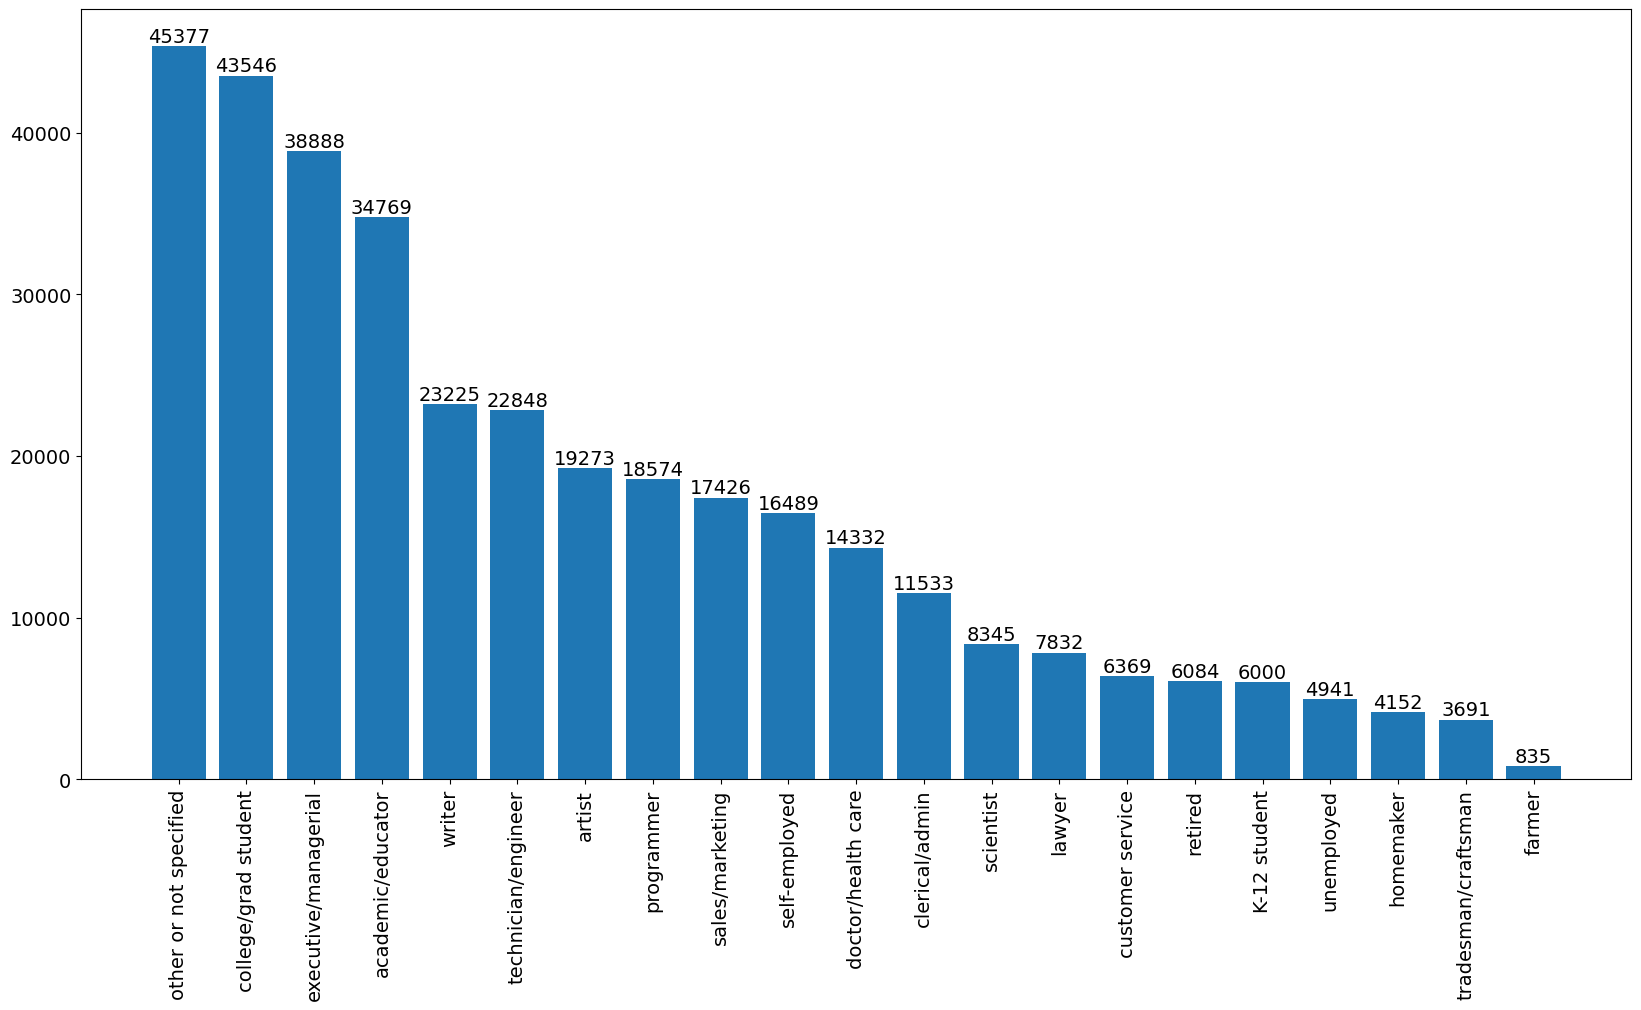

In [ ]:
occupation_id_count = movies_drama["Occupation"].value_counts().to_dict()
occupation_count = {
    occupation_mapping[id]: count for id, count in occupation_id_count.items()
}

matplotlib.rcParams.update({"font.size": 14})
plt.figure(figsize=(20, 10))
bars = plt.bar(x=occupation_count.keys(), height=occupation_count.values())
plt.xticks(rotation=90)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

plt.show()

Rating

In [ ]:
rating_count_drama_viewers = movies_drama['Rating'].value_counts()

print("Rating distribution of drama viewers", rating_count_drama_viewers)

Rating distribution of drama viewers Rating
4    131811
5     96629
3     84821
2     29154
1     12114
Name: count, dtype: int64


In [ ]:
mean_rating_drama_viewers = movies_drama['Rating'].mean()

print("Mean rating of drama viewers", mean_rating_drama_viewers)

Mean rating of drama viewers 3.766332232342065


# Comedy

In [ ]:
movies_comedy = merged_data[merged_data['Genres'].str.contains('Comedy')]
movies_comedy.info()
movies_comedy.head()

<class 'pandas.core.frame.DataFrame'>
Index: 356580 entries, 4201 to 1000207
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   UserID      356580 non-null  int64 
 1   MovieID     356580 non-null  int64 
 2   Rating      356580 non-null  int64 
 3   Timestamp   356580 non-null  int64 
 4   Gender      356580 non-null  object
 5   Age         356580 non-null  int64 
 6   Occupation  356580 non-null  int64 
 7   Zip-code    356580 non-null  object
 8   Title       356580 non-null  object
 9   Genres      356580 non-null  object
 10  num_genres  356580 non-null  int64 
dtypes: int64(7), object(4)
memory usage: 32.6+ MB


,UserID,MovieID,Rating,Timestamp,Gender,Age,Occupation,Zip-code,Title,Genres,num_genres
4201,1,2355,5,978824291,F,1,10,48067,"Bug's Life, A (1998)",Animation|Children's|Comedy,3
4202,3,2355,5,978298430,M,25,15,55117,"Bug's Life, A (1998)",Animation|Children's|Comedy,3
4203,5,2355,5,978241981,M,25,20,55455,"Bug's Life, A (1998)",Animation|Children's|Comedy,3
4204,9,2355,4,978226054,M,25,17,61614,"Bug's Life, A (1998)",Animation|Children's|Comedy,3
4205,10,2355,4,978226500,F,35,1,95370,"Bug's Life, A (1998)",Animation|Children's|Comedy,3


Độ tuổi

In [ ]:
mean_age_comedy_viewers = movies_comedy['Age'].mean() # giá trị trung bình độ tuổi
median_age_comedy_viewers = movies_comedy['Age'].median() # giá trị độ tuổi ở vị trí giữa của tập hợp các độ tuổi
mode_age_comedy_viewers = movies_comedy['Age'].mode() # độ tuổi xuất hiện nhiều nhất

print("Mean age of comedy viewers:", mean_age_comedy_viewers)
print("Median age of comedy viewers:", median_age_comedy_viewers)
print("Mode age of comedy viewers:", mode_age_comedy_viewers)

Mean age of comedy viewers: 29.042873969375737
Median age of comedy viewers: 25.0
Mode age of comedy viewers: 0    25
Name: Age, dtype: int64


Giới tính

In [ ]:
gender_count_comedy_viewers = movies_comedy['Gender'].value_counts()

print("Gender distribution of comedy viewers:", gender_count_comedy_viewers)

Gender distribution of comedy viewers: Gender
M    260309
F     96271
Name: count, dtype: int64


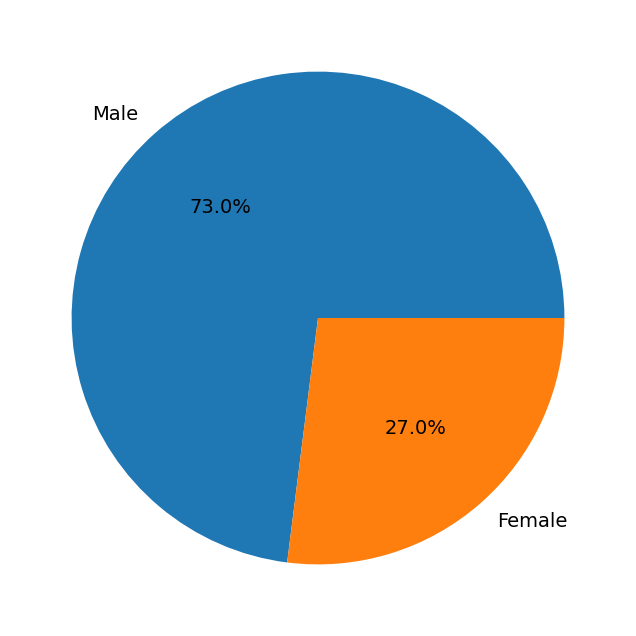

In [ ]:
gender = ['Male', 'Female']
gender_counts = movies_comedy['Gender'].value_counts()

fig = plt.figure(figsize=(8,8))
plt.pie(gender_counts, labels=gender, autopct='%1.1f%%')
plt.show()

Nghề nghiệp

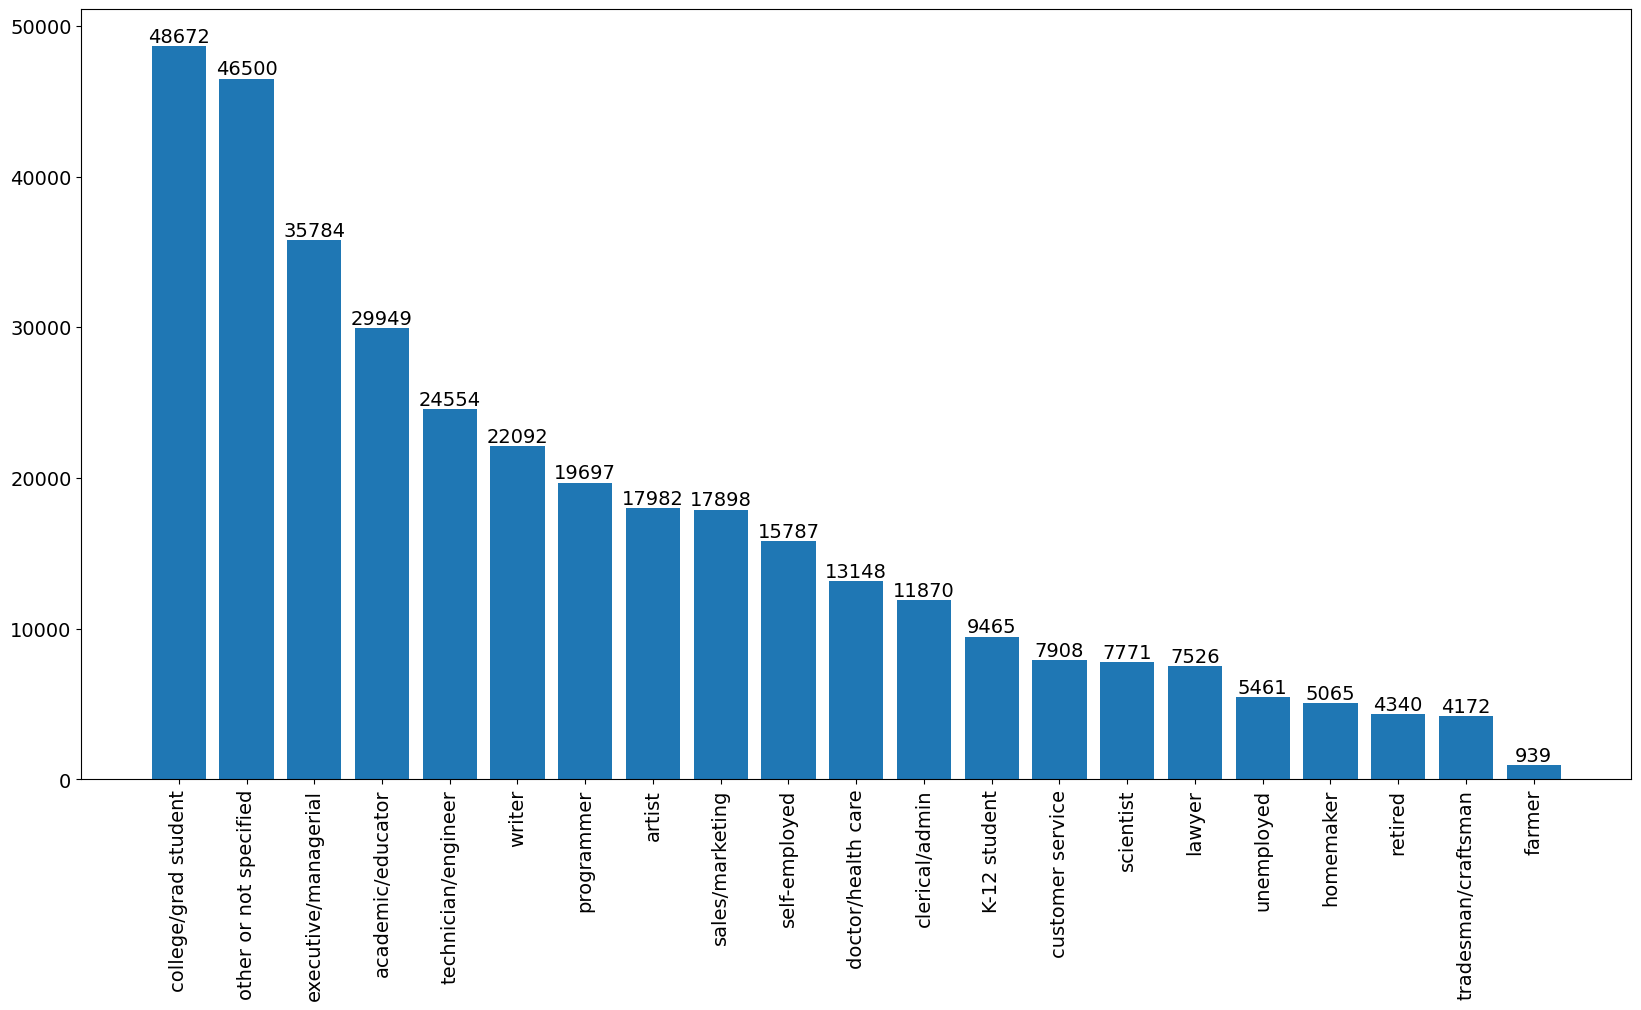

In [ ]:
occupation_id_count = movies_comedy["Occupation"].value_counts().to_dict()
occupation_count = {
    occupation_mapping[id]: count for id, count in occupation_id_count.items()
}

matplotlib.rcParams.update({"font.size": 14})
plt.figure(figsize=(20, 10))
bars = plt.bar(x=occupation_count.keys(), height=occupation_count.values())
plt.xticks(rotation=90)

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f"{height}",
        ha="center",
        va="bottom"
    )

plt.show()

Rating

In [ ]:
rating_count_comedy_viewers = movies_comedy['Rating'].value_counts()

print("Rating distribution of comedy viewers", rating_count_comedy_viewers)

Rating distribution of comedy viewers Rating
4    123415
3     96946
5     73530
2     41073
1     21616
Name: count, dtype: int64


In [ ]:
mean_rating_comedy_viewers = movies_comedy['Rating'].mean()

print("Mean rating of comedy viewers", mean_rating_comedy_viewers)

Mean rating of comedy viewers 3.522098827752538


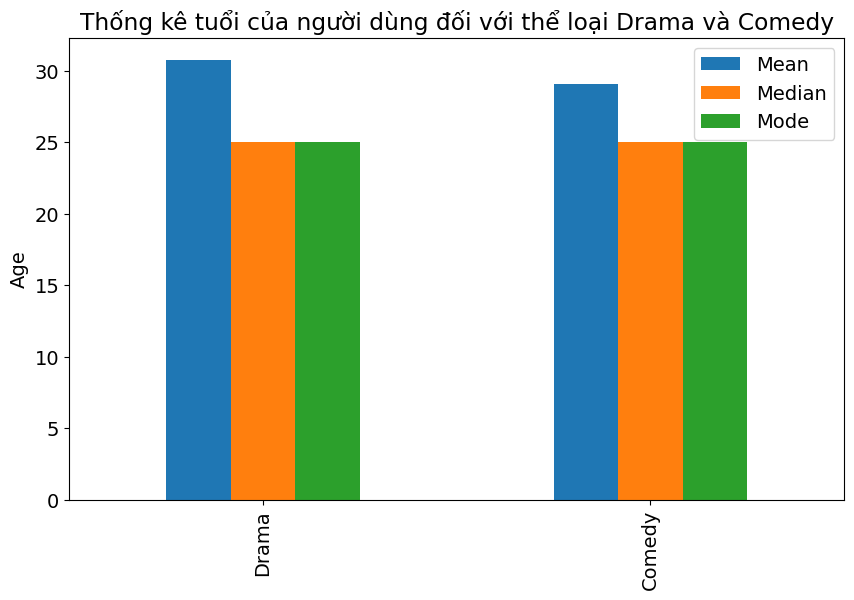

In [ ]:
movies_drama_comedy = merged_data[merged_data['Genres'].str.contains('Drama|Comedy')]

movies_drama = movies_drama_comedy[movies_drama_comedy['Genres'].str.contains('Drama')]
movies_comedy = movies_drama_comedy[movies_drama_comedy['Genres'].str.contains('Comedy')]

mean_age_drama = movies_drama['Age'].mean()
mean_age_comedy = movies_comedy['Age'].mean()

median_age_drama = movies_drama['Age'].median()
median_age_comedy = movies_comedy['Age'].median()

mode_age_drama = movies_drama['Age'].mode()[0]
mode_age_comedy = movies_comedy['Age'].mode()[0]

age_stats = pd.DataFrame({
    'Mean': [mean_age_drama, mean_age_comedy],
    'Median': [median_age_drama, median_age_comedy],
    'Mode': [mode_age_drama, mode_age_comedy]
}, index=['Drama', 'Comedy'])

age_stats.plot(kind='bar', figsize=(10, 6))
plt.title('Thống kê tuổi của người dùng đối với thể loại Drama và Comedy')
plt.ylabel('Age')
plt.show()

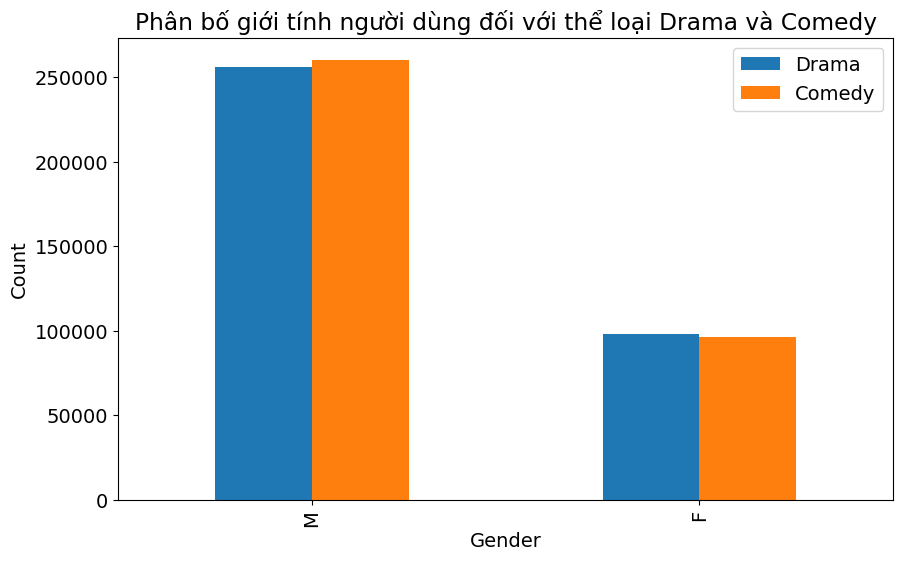

In [ ]:
gender_counts_drama = movies_drama['Gender'].value_counts()
gender_counts_comedy = movies_comedy['Gender'].value_counts()

gender_counts = pd.DataFrame({
    'Drama': gender_counts_drama,
    'Comedy': gender_counts_comedy
})

gender_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Phân bố giới tính người dùng đối với thể loại Drama và Comedy')
plt.ylabel('Count')
plt.show()

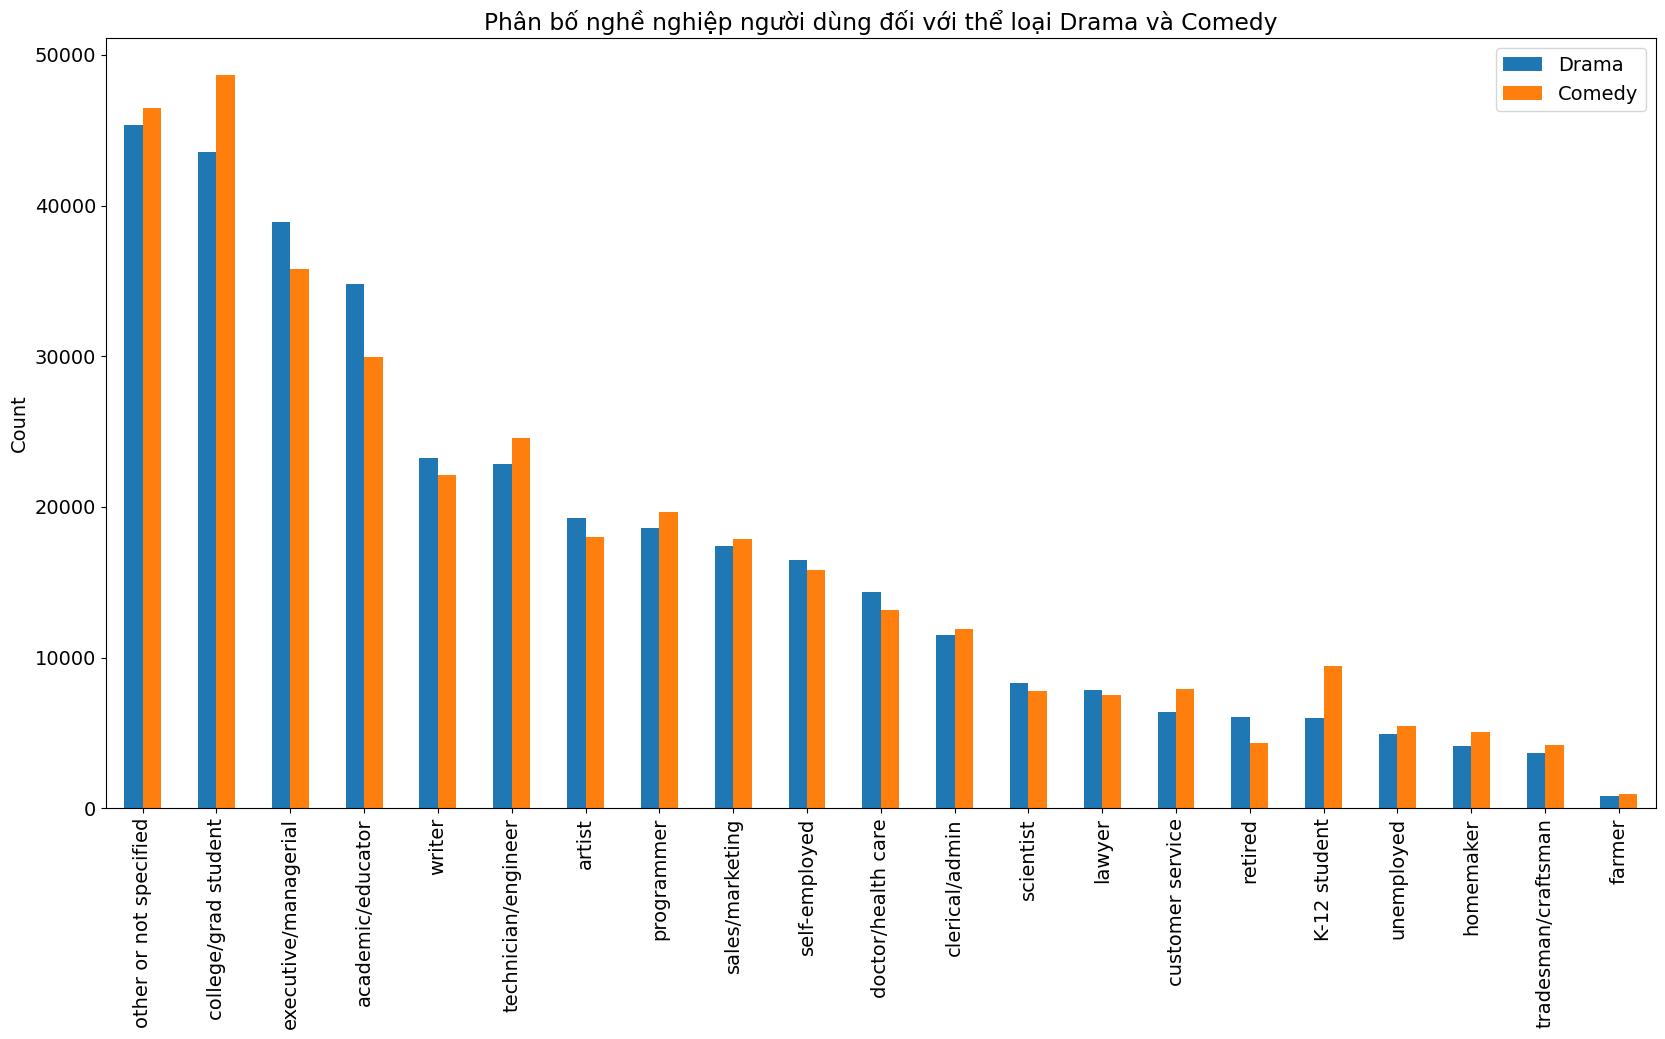

In [ ]:
occupation_counts_drama = movies_drama["Occupation"].value_counts().to_dict()
occupation_counts_comedy = movies_comedy["Occupation"].value_counts().to_dict()

occupation_count_drama = {occupation_mapping[id]: count for id, count in occupation_counts_drama.items()}
occupation_count_comedy = {occupation_mapping[id]: count for id, count in occupation_counts_comedy.items()}

occupation_df = pd.DataFrame({
    'Drama': occupation_count_drama,
    'Comedy': occupation_count_comedy
}).fillna(0)

occupation_df.plot(kind='bar', figsize=(20, 10))
plt.title('Phân bố nghề nghiệp người dùng đối với thể loại Drama và Comedy')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

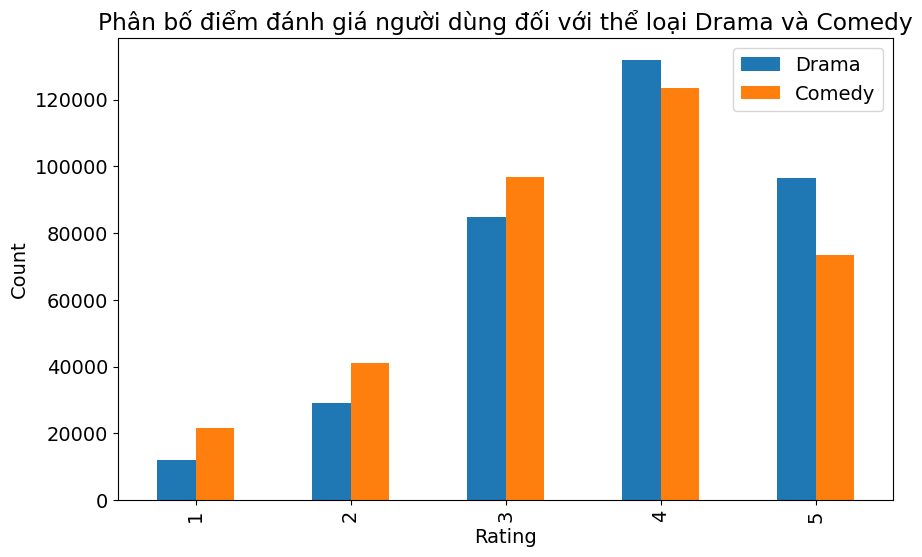

In [ ]:
rating_counts_drama = movies_drama['Rating'].value_counts()
rating_counts_comedy = movies_comedy['Rating'].value_counts()

rating_counts = pd.DataFrame({
    'Drama': rating_counts_drama,
    'Comedy': rating_counts_comedy
}).fillna(0)

rating_counts.plot(kind='bar', figsize=(10, 6))
plt.title('Phân bố điểm đánh giá người dùng đối với thể loại Drama và Comedy')
plt.ylabel('Count')
plt.show()

In [ ]:
mean_rating_drama = movies_drama['Rating'].mean()
mean_rating_comedy = movies_comedy['Rating'].mean()

print("Mean rating of drama viewers:", mean_rating_drama)
print("Mean rating of comedy viewers:", mean_rating_comedy)

Mean rating of drama viewers: 3.766332232342065
Mean rating of comedy viewers: 3.522098827752538
